# Library

In [1]:
#Library to dataset
import os
import numpy as np
import pandas as pd

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import EfficientNetV2S

# Others
import shutil
import random
import librosa

# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from mlxtend.plotting import plot_confusion_matrix

# Image Dataset

In [2]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Train",
    label_mode="categorical",
    class_names=['Yes','No'],
    color_mode="rgb",
    batch_size=1,
    image_size=(700, 700),
    shuffle=False,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Validation",
    label_mode="categorical",
    class_names=['Yes','No'],
    color_mode="rgb",
    batch_size=1,
    image_size=(700, 700),
    shuffle=False,
    seed=123
)

==========================Training Data====================
Found 1192 files belonging to 2 classes.
==========================Validation Data====================
Found 296 files belonging to 2 classes.


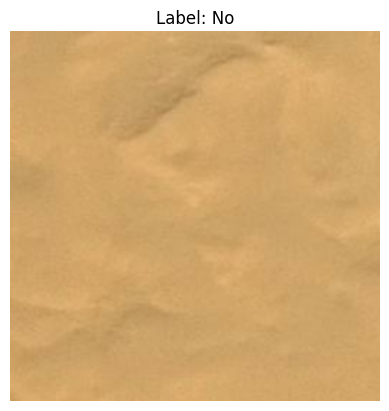

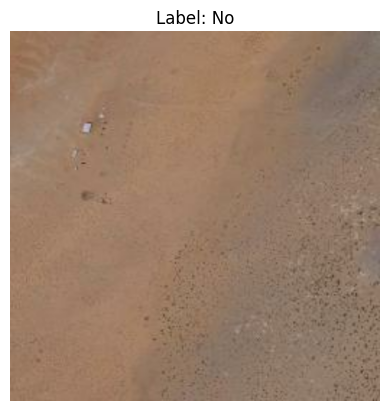

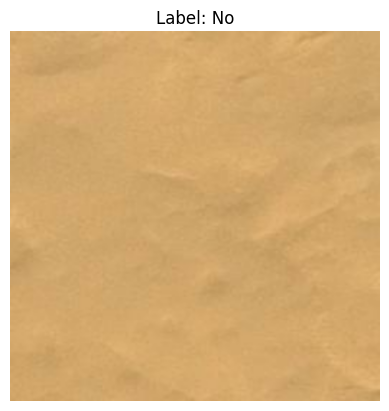

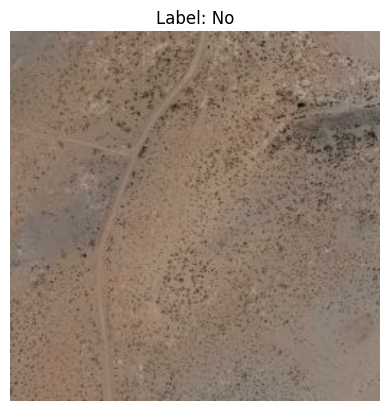

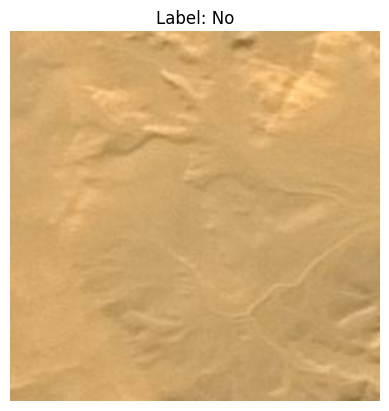

In [3]:
# Display 5 images from the training data
# Take 5 random samples
random_samples = train_data.take(5)

# Display the random samples
for images, labels in random_samples:
    image = images[0]
    label = labels[0]
    label_index = tf.argmax(label).numpy()
    label_name = train_data.class_names[label_index]

    plt.imshow(image.numpy().astype("uint8"))
    plt.title("Label: {}".format(label_name))
    plt.axis("off")
    plt.show()

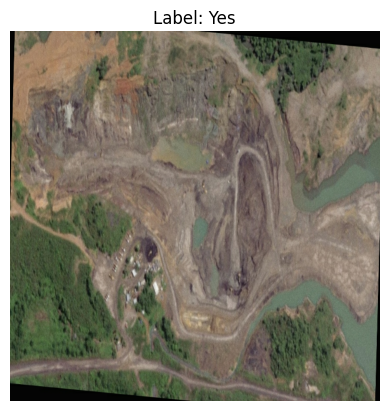

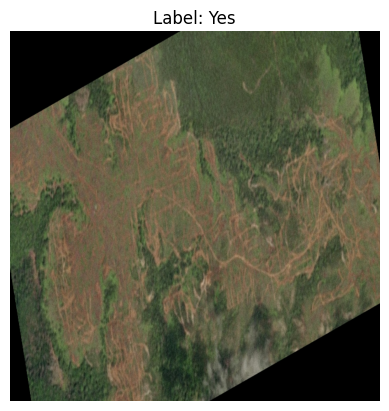

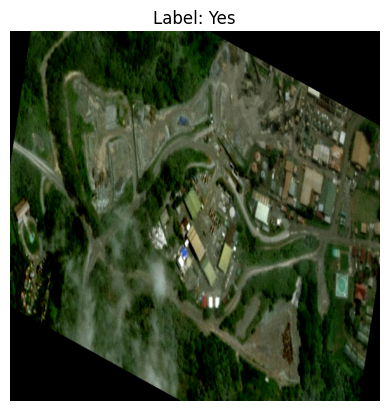

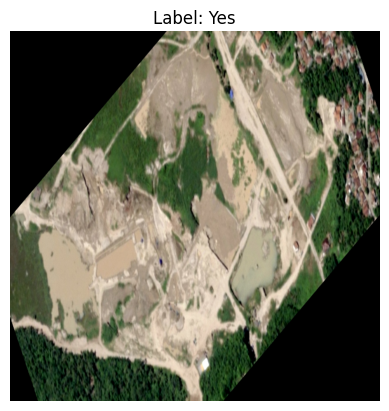

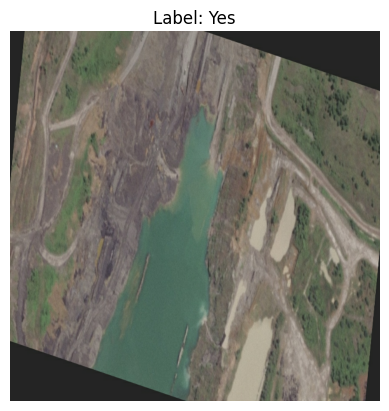

In [4]:
# Take 5 random samples with label "Yes"
random_samples = []
for image, labels in train_data:
    label = labels[0]
    label_index = tf.argmax(label).numpy()
    label_name = train_data.class_names[label_index]
    if label_name == 'Yes':
        random_samples.append((image, label))
        if len(random_samples) == 5:
            break

# Display the random samples
for image, label in random_samples:
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.title("Label: Yes")
    plt.axis("off")
    plt.show()

In [5]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/255)

test_datagen  = ImageDataGenerator(rescale = 1.0/255)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Train",
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    target_size=(700, 700),
                                                    shuffle=False)     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Validation",
                                                         batch_size=1,
                                                         class_mode  = 'categorical',
                                                         target_size = (700, 700),
                                                         shuffle=False)

Found 1192 images belonging to 2 classes.
Found 296 images belonging to 2 classes.


In [6]:
# Check the class indices
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'No': 0, 'Yes': 1}
{'No': 0, 'Yes': 1}


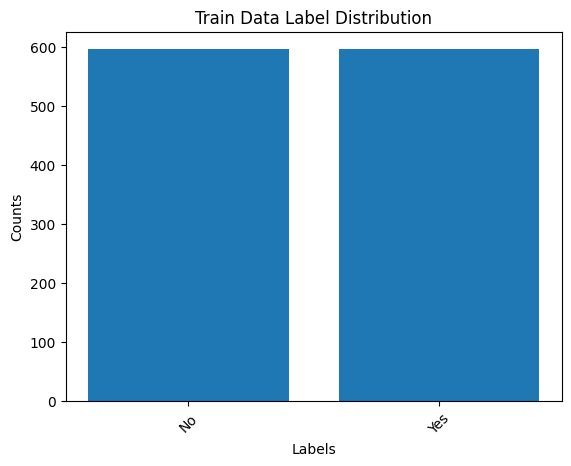

In [7]:
# Check Label Distribution
train_label_dist = {}

for _ in range(len(train_generator)):
    _, labels = train_generator.next()
    for label in labels:
        label_name = list(train_generator.class_indices.keys())[label.argmax()]
        if label_name not in train_label_dist:
            train_label_dist[label_name] = 0
        train_label_dist[label_name] += 1

# Extract labels and counts
labels = list(train_label_dist.keys())
counts = list(train_label_dist.values())

# Plot the label distribution
plt.bar(labels, counts)
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Train Data Label Distribution")
plt.xticks(rotation=45)
plt.show()

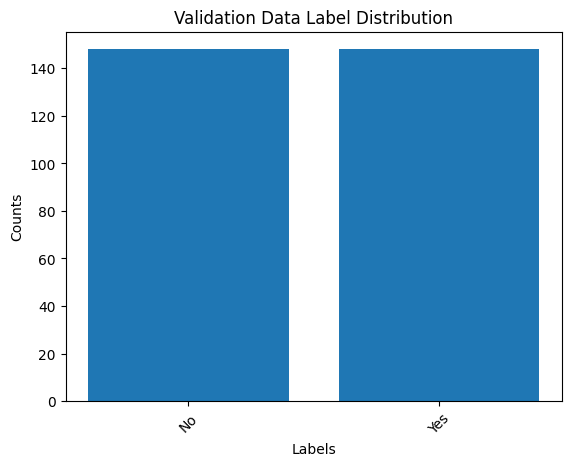

In [8]:
# Label distribution for validation set
valid_label_dist = {}

for _ in range(len(validation_generator)):
    _, labels = validation_generator.next()
    for label in labels:
        label_name = list(validation_generator.class_indices.keys())[label.argmax()]
        if label_name not in valid_label_dist:
            valid_label_dist[label_name] = 0
        valid_label_dist[label_name] += 1

# Extract labels and counts
labels = list(valid_label_dist.keys())
counts = list(valid_label_dist.values())

# Plot the label distribution
plt.bar(labels, counts)
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Validation Data Label Distribution")
plt.xticks(rotation=45)
plt.show()

# Modelling DIY

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="DIY.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define Basic Model
DIY_Model  = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.InputLayer(input_shape=(700, 700, 3)),
    # Convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    # Max pooling layer
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    # Convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # Max pooling layer
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    # Convolutional layer
    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    # Max pooling layer
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(128, activation='relu'),
    # Dropout layer
    tf.keras.layers.Dropout(0.2),
    # Output layer
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
DIY_Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
DIY_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 698, 698, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 349, 349, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 347, 347, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 174, 174, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 173, 173, 128)     32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 87, 87, 128)      0

In [11]:
# Train the model
history = DIY_Model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
1192/1192 [==============================] - ETA: 0s - loss: 0.4626 - accuracy: 0.9203
Epoch 1: val_accuracy improved from -inf to 0.97973, saving model to DIY.h5
1192/1192 [==============================] - 49s 35ms/step - loss: 0.4626 - accuracy: 0.9203 - val_loss: 0.0640 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 2/100
1192/1192 [==============================] - ETA: 0s - loss: 0.4201 - accuracy: 0.9547
Epoch 2: val_accuracy did not improve from 0.97973
1192/1192 [==============================] - 37s 31ms/step - loss: 0.4201 - accuracy: 0.9547 - val_loss: 0.2969 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 3/100
1190/1192 [============================>.] - ETA: 0s - loss: 0.5464 - accuracy: 0.9168
Epoch 3: val_accuracy did not improve from 0.97973
1192/1192 [==============================] - 37s 31ms/step - loss: 0.5456 - accuracy: 0.9169 - val_loss: 0.1955 - val_accuracy: 0.9628 - lr: 0.0010
Epoch 4/100
1191/1192 [============================>.] - ETA: 0s - loss: 0.1851 -

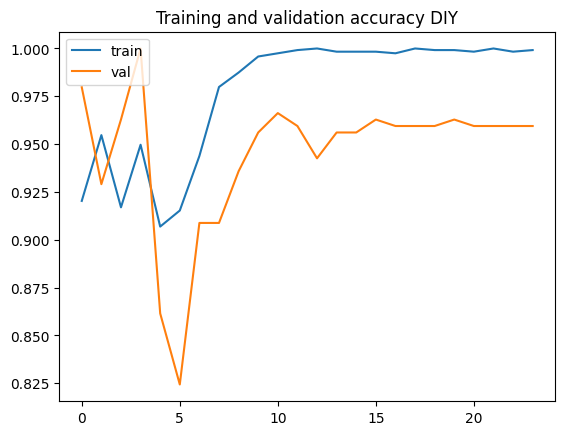

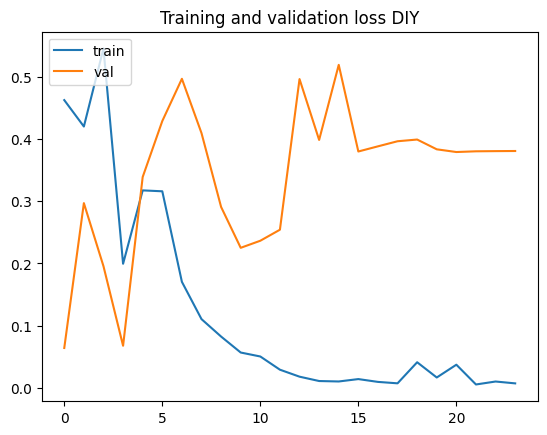

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy' ]
val_acc  = history.history['val_accuracy' ]
loss     = history.history['loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY')
plt.legend(['train', 'val'], loc='upper left')

In [13]:
# Evaluate the model
test_loss, test_acc = DIY_Model.evaluate(validation_generator, verbose=1)
# Print out the model accuracy
print("Test accuracy:", test_acc)
# Print out the model loss
print("Test loss:", test_loss)

296/296 [==============================] - 3s 11ms/step - loss: 0.0676 - accuracy: 1.0000
Test accuracy: 1.0
Test loss: 0.06756963580846786


# Modelling MobileNet V2

In [14]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="MobileNetV2.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [15]:
# Define Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(700, 700, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])

# Freeze the MobileNetV2 layers
MobileNetV2_model.layers[0].trainable = False

# Compile Model
MobileNetV2_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 22, 22, 1280)     2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,586,434
Trainable params: 328,450
Non-

In [16]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
1190/1192 [============================>.] - ETA: 0s - loss: 0.1615 - accuracy: 0.9891
Epoch 1: val_accuracy improved from -inf to 0.99662, saving model to MobileNetV2.h5
1192/1192 [==============================] - 25s 19ms/step - loss: 0.1612 - accuracy: 0.9891 - val_loss: 0.0218 - val_accuracy: 0.9966 - lr: 0.0010
Epoch 2/100
1192/1192 [==============================] - ETA: 0s - loss: 1.4021e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.99662
1192/1192 [==============================] - 22s 19ms/step - loss: 1.4021e-05 - accuracy: 1.0000 - val_loss: 0.0423 - val_accuracy: 0.9966 - lr: 0.0010
Epoch 3/100
1192/1192 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9975
Epoch 3: val_accuracy improved from 0.99662 to 1.00000, saving model to MobileNetV2.h5
1192/1192 [==============================] - 22s 18ms/step - loss: 0.0540 - accuracy: 0.9975 - val_loss: 2.1194e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
1189/1192 [==

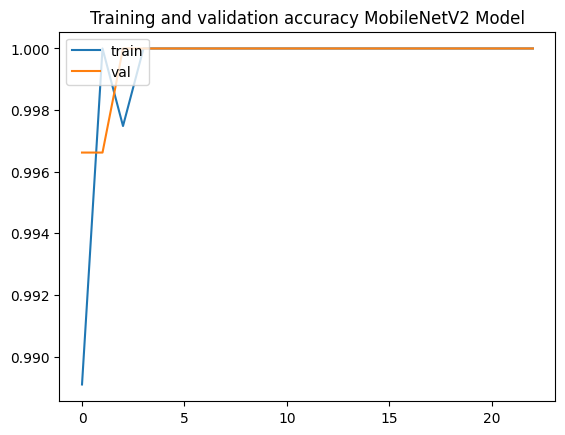

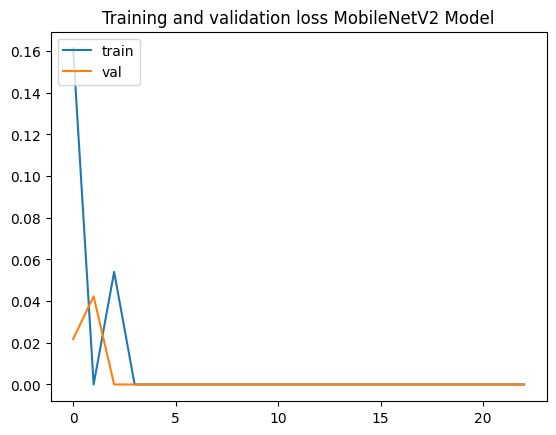

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model')
plt.legend(['train', 'val'], loc='upper left')

In [18]:
# Evaluate the model
test_loss, test_acc = MobileNetV2_model.evaluate(validation_generator, verbose=1)
# Print out the model accuracy
print("Test accuracy:", test_acc)
# Print out the model loss

296/296 [==============================] - 4s 14ms/step - loss: 2.1194e-08 - accuracy: 1.0000
Test accuracy: 1.0


# Modelling DenseNet 121

In [19]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="DenseNet121.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [20]:
# Define Model
DenseNet121_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(700, 700, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax')
    ])

# Freeze the DenseNet121 layers
DenseNet121_model.layers[0].trainable = False

# Compile Model
DenseNet121_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Model Summary
DenseNet121_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 21, 21, 1024)      7037504   
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1024)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7,300,418
Trainable params: 262,914
Non-trainable params: 7,037,504
______________________________________

In [21]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet121_model = DenseNet121_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
1191/1192 [============================>.] - ETA: 0s - loss: 0.0559 - accuracy: 0.9933
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to DenseNet121.h5
1192/1192 [==============================] - 47s 35ms/step - loss: 0.0558 - accuracy: 0.9933 - val_loss: 3.2932e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/100
1192/1192 [==============================] - ETA: 0s - loss: 7.7493e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
1192/1192 [==============================] - 40s 33ms/step - loss: 7.7493e-04 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 0.9932 - lr: 0.0010
Epoch 3/100
1191/1192 [============================>.] - ETA: 0s - loss: 1.9696e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
1192/1192 [==============================] - 40s 34ms/step - loss: 1.9680e-05 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 0.9966 - lr: 0.0010
Epoch 4/100
1191/1192 [============================>.

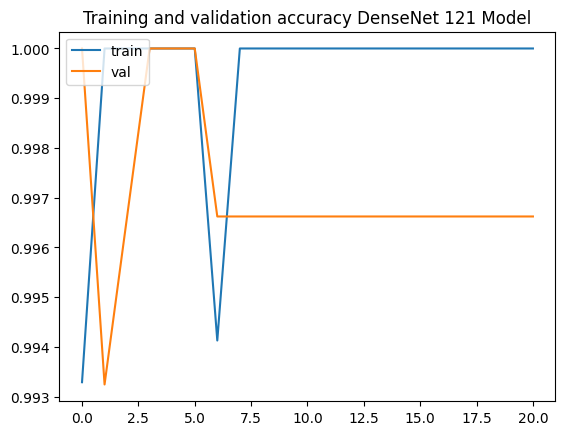

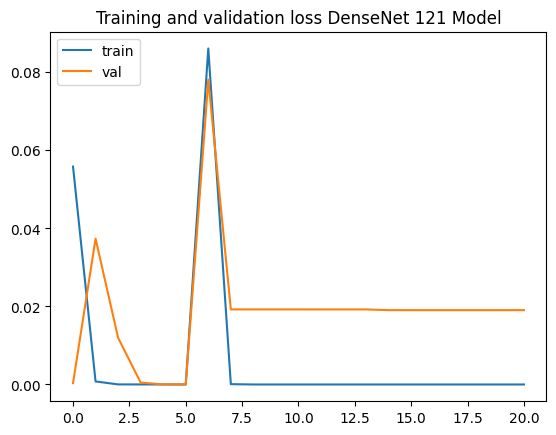

In [22]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet121_model.history['accuracy' ]
val_acc  = history_DenseNet121_model.history['val_accuracy' ]
loss     = history_DenseNet121_model.history['loss' ]
val_loss = history_DenseNet121_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet 121 Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet 121 Model')
plt.legend(['train', 'val'], loc='upper left')

In [23]:
# Evaluate the model
test_loss, test_acc = DenseNet121_model.evaluate(validation_generator, verbose=1)
# Print out the model accuracy
print("Test accuracy:", test_acc)
# Print out the model loss
print("Test loss:", test_loss)

296/296 [==============================] - 8s 27ms/step - loss: 3.2932e-04 - accuracy: 1.0000
Test accuracy: 1.0
Test loss: 0.00032932471367530525


# Modelling Xception

In [24]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Xception.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [25]:
# Define Model
Xception_model = tf.keras.models.Sequential([
    # Xception Layer
    Xception(include_top=False,weights='imagenet',input_shape=(700, 700, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax')
    ])

# Freeze the Xception layers
Xception_model.layers[0].trainable = False

# Compile Model
Xception_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Model Summary
Xception_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 22, 22, 2048)      20861480  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,386,538
Trainable params: 525,058
Non-trainable params: 20,861,480
____________________________________

In [26]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model = Xception_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
1191/1192 [============================>.] - ETA: 0s - loss: 0.0360 - accuracy: 0.9941
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to Xception.h5
1192/1192 [==============================] - 50s 39ms/step - loss: 0.0360 - accuracy: 0.9941 - val_loss: 1.5330e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/100
1192/1192 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9941
Epoch 2: val_accuracy did not improve from 1.00000
1192/1192 [==============================] - 46s 39ms/step - loss: 0.0327 - accuracy: 0.9941 - val_loss: 1.4781e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
1192/1192 [==============================] - ETA: 0s - loss: 1.1296e-11 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
1192/1192 [==============================] - 46s 39ms/step - loss: 1.1296e-11 - accuracy: 1.0000 - val_loss: 1.4781e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
1191/1192 [============================>.] -

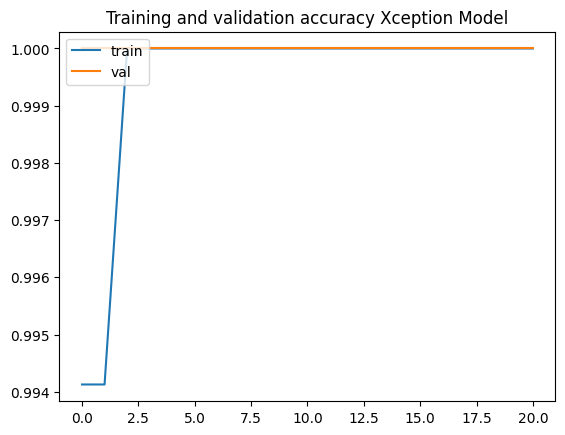

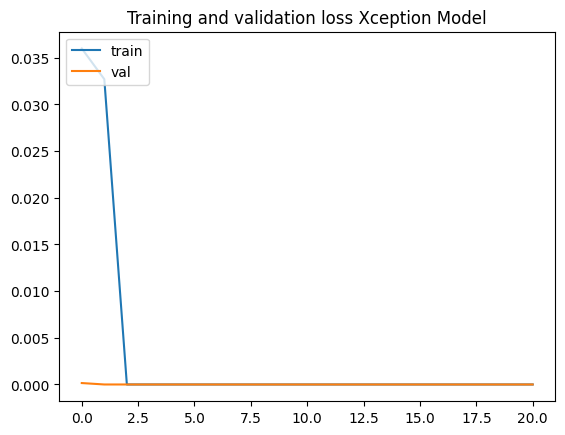

In [27]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model.history['accuracy' ]
val_acc  = history_Xception_model.history['val_accuracy' ]
loss     = history_Xception_model.history['loss' ]
val_loss = history_Xception_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy Xception Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss Xception Model')
plt.legend(['train', 'val'], loc='upper left')

In [28]:
# Evaluate the model
test_loss, test_acc = Xception_model.evaluate(validation_generator, verbose=1)
# Print out the model accuracy
print("Test accuracy:", test_acc)
# Print out the model loss
print("Test loss:", test_loss)

296/296 [==============================] - 9s 31ms/step - loss: 1.5330e-04 - accuracy: 1.0000
Test accuracy: 1.0
Test loss: 0.00015330121095757931


# Modelling EfficientNetV2S

In [29]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="EfficientNetV2S.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [46]:
# Define Model
EfficientNetV2S_model = tf.keras.models.Sequential([
    # EfficientNetV2S Layer
    EfficientNetV2S(include_top=False,weights='imagenet',input_shape=(700, 700, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax')
    ])

# Freeze the EfficientNetV2S layers
EfficientNetV2S_model.layers[0].trainable = False

# Compile Model
EfficientNetV2S_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Model Summary
EfficientNetV2S_model.summary()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of af0682fb74e8c54910f2d4393339c070 so we will re-download the data.
82420632/82420632 [==============================] - 1202s 15us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 22, 22, 1280)     20331360  
 l)                                                              
                                                                 
 global_max_pooling2d_3 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 256)             

In [47]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_EfficientNetV2S_model = EfficientNetV2S_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
1192/1192 [==============================] - ETA: 0s - loss: 5.5906 - accuracy: 0.6409
Epoch 1: val_accuracy improved from -inf to 0.92230, saving model to EfficientNetV2S.h5
1192/1192 [==============================] - 74s 54ms/step - loss: 5.5906 - accuracy: 0.6409 - val_loss: 0.3006 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 2/100
1192/1192 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.5847
Epoch 2: val_accuracy did not improve from 0.92230
1192/1192 [==============================] - 61s 51ms/step - loss: 0.7037 - accuracy: 0.5847 - val_loss: 0.6931 - val_accuracy: 0.5068 - lr: 0.0010
Epoch 3/100
1192/1192 [==============================] - ETA: 0s - loss: 0.7689 - accuracy: 0.5529
Epoch 3: val_accuracy did not improve from 0.92230
1192/1192 [==============================] - 60s 51ms/step - loss: 0.7689 - accuracy: 0.5529 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
1192/1192 [==============================] - ETA: 0s - lo

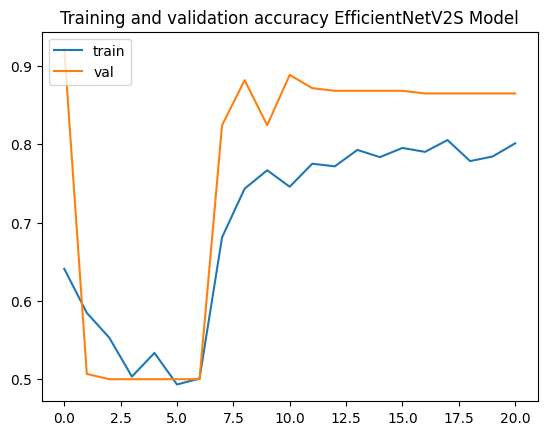

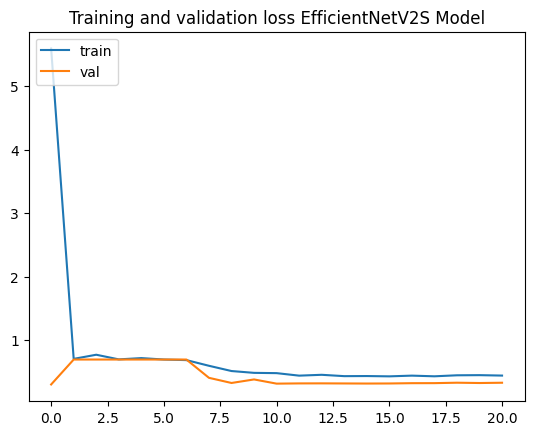

In [48]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_EfficientNetV2S_model.history['accuracy' ]
val_acc  = history_EfficientNetV2S_model.history['val_accuracy' ]
loss     = history_EfficientNetV2S_model.history['loss' ]
val_loss = history_EfficientNetV2S_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy EfficientNetV2S Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss EfficientNetV2S Model')
plt.legend(['train', 'val'], loc='upper left')

In [49]:
# Evaluate the model
test_loss, test_acc = EfficientNetV2S_model.evaluate(validation_generator, verbose=1)
# Print out the model accuracy
print("Test accuracy:", test_acc)
# Print out the model loss
print("Test loss:", test_loss)

296/296 [==============================] - 15s 50ms/step - loss: 0.3006 - accuracy: 0.9223
Test accuracy: 0.9222972989082336
Test loss: 0.30056262016296387


# Model Evaluation

# DIY Model Evaluation

In [50]:
# evaluate model
print("==========================Evaluate Model====================")
scores_DIY = DIY_Model.evaluate(validation_generator, verbose=1)
print("Accuracy: %.6f%%" % (scores_DIY[1]*100))
print("Loss: %.6f%%" % (scores_DIY[0]*100))

==========================Evaluate Model====================
296/296 [==============================] - 3s 11ms/step - loss: 0.0676 - accuracy: 1.0000
Accuracy: 100.000000%
Loss: 6.756964%


==========================Confusion Matrix====================
296/296 [==============================] - 3s 11ms/step


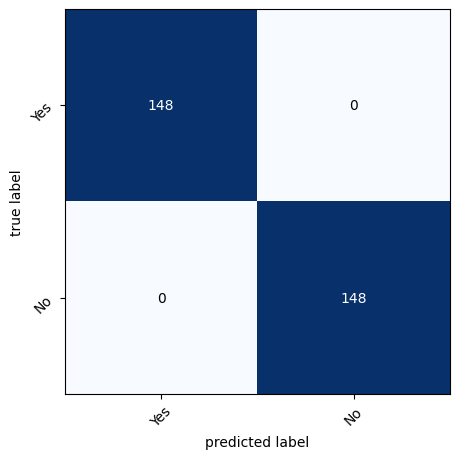

==========================Classification Report====================
Classification Report
              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00       148
          No       1.00      1.00      1.00       148

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296

==========================F1 Score====================
F1 Score: 1.0


In [51]:
# Confusion Matrix and Classification Report
target_names = ['Yes', 'No']
# Plot confusion matrix
print("==========================Confusion Matrix====================")
Y_pred = DIY_Model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, Y_pred_classes)
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
ax.set_xticklabels([''] + target_names, rotation=45)
ax.set_yticklabels([''] + target_names, rotation=45)
plt.show()

print("==========================Classification Report====================")
print('Classification Report')
print(classification_report(validation_generator.classes, Y_pred_classes, target_names=target_names))

# F1 Score
print("==========================F1 Score====================")
f1_DIY = f1_score(validation_generator.classes, Y_pred_classes, average='weighted')
print('F1 Score:', f1_DIY)

# MobileNet V2 Evaluation

In [52]:
# evaluate model
print("==========================Evaluate Model====================")
scores_MobileNetV2 = MobileNetV2_model.evaluate(validation_generator, verbose=1)
print("Accuracy: %.6f%%" % (scores_MobileNetV2[1]*100))
print("Loss: %.6f%%" % (scores_MobileNetV2[0]*100))

==========================Evaluate Model====================
296/296 [==============================] - 5s 16ms/step - loss: 2.1194e-08 - accuracy: 1.0000
Accuracy: 100.000000%
Loss: 0.000002%


==========================Confusion Matrix====================


296/296 [==============================] - 4s 15ms/step


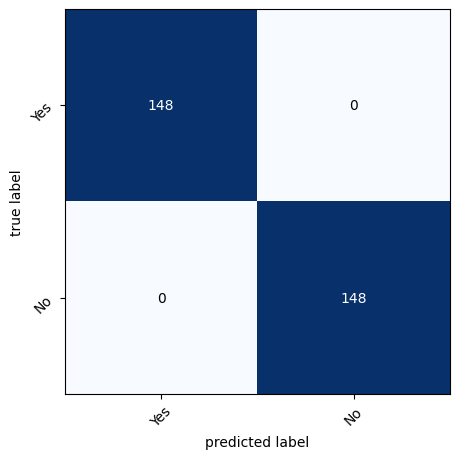

==========================Classification Report====================
Classification Report
              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00       148
          No       1.00      1.00      1.00       148

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296

==========================F1 Score====================
F1 Score: 1.0


In [53]:
# Confusion Matrix and Classification Report
target_names = ['Yes', 'No']
# Plot confusion matrix
print("==========================Confusion Matrix====================")
Y_pred = MobileNetV2_model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, Y_pred_classes)
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
ax.set_xticklabels([''] + target_names, rotation=45)
ax.set_yticklabels([''] + target_names, rotation=45)
plt.show()

print("==========================Classification Report====================")
print('Classification Report')
print(classification_report(validation_generator.classes, Y_pred_classes, target_names=target_names))

# F1 Score
print("==========================F1 Score====================")
f1_MobileNetV2 = f1_score(validation_generator.classes, Y_pred_classes, average='weighted')
print('F1 Score:', f1_MobileNetV2)

# DenseNet121 Evaluation

In [54]:
# evaluate model
print("==========================Evaluate Model====================")
scores_DenseNet121 = DenseNet121_model.evaluate(validation_generator, verbose=1)
print("Accuracy: %.6f%%" % (scores_DenseNet121[1]*100))
print("Loss: %.6f%%" % (scores_DenseNet121[0]*100))

==========================Evaluate Model====================
296/296 [==============================] - 10s 34ms/step - loss: 3.2932e-04 - accuracy: 1.0000
Accuracy: 100.000000%
Loss: 0.032932%


==========================Confusion Matrix====================
296/296 [==============================] - 9s 31ms/step


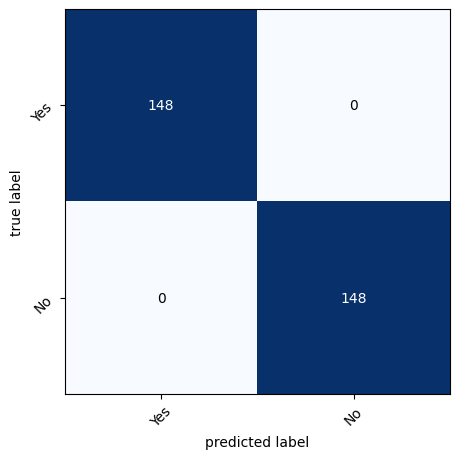

==========================Classification Report====================
Classification Report
              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00       148
          No       1.00      1.00      1.00       148

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296

==========================F1 Score====================
F1 Score: 1.0


In [55]:
# Confusion Matrix and Classification Report
target_names = ['Yes', 'No']
# Plot confusion matrix
print("==========================Confusion Matrix====================")
Y_pred = DenseNet121_model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, Y_pred_classes)
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
ax.set_xticklabels([''] + target_names, rotation=45)
ax.set_yticklabels([''] + target_names, rotation=45)
plt.show()

print("==========================Classification Report====================")
print('Classification Report')
print(classification_report(validation_generator.classes, Y_pred_classes, target_names=target_names))

# F1 Score
print("==========================F1 Score====================")
f1_DenseNet121 = f1_score(validation_generator.classes, Y_pred_classes, average='weighted')
print('F1 Score:', f1_DenseNet121)

# Xception Evaluation

In [56]:
# evaluate model
print("==========================Evaluate Model====================")
scores_Xception = Xception_model.evaluate(validation_generator, verbose=1)
print("Accuracy: %.6f%%" % (scores_Xception[1]*100))
print("Loss: %.6f%%" % (scores_Xception[0]*100))

==========================Evaluate Model====================
296/296 [==============================] - 13s 44ms/step - loss: 1.5330e-04 - accuracy: 1.0000
Accuracy: 100.000000%
Loss: 0.015330%


==========================Confusion Matrix====================
296/296 [==============================] - 13s 43ms/step


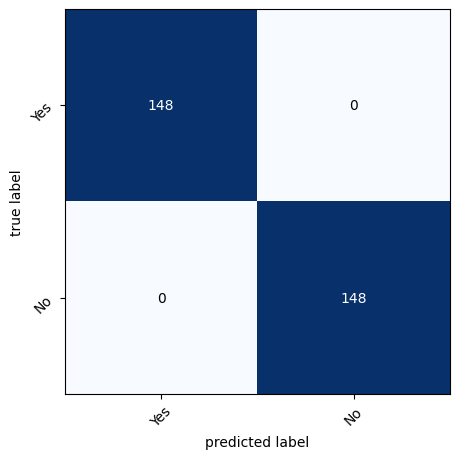

==========================Classification Report====================
Classification Report
              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00       148
          No       1.00      1.00      1.00       148

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296

==========================F1 Score====================
F1 Score: 1.0


In [57]:
# Confusion Matrix and Classification Report
target_names = ['Yes', 'No']
# Plot confusion matrix
print("==========================Confusion Matrix====================")
Y_pred = Xception_model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, Y_pred_classes)
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
ax.set_xticklabels([''] + target_names, rotation=45)
ax.set_yticklabels([''] + target_names, rotation=45)
plt.show()

print("==========================Classification Report====================")
print('Classification Report')
print(classification_report(validation_generator.classes, Y_pred_classes, target_names=target_names))

# F1 Score
print("==========================F1 Score====================")
f1_Xception = f1_score(validation_generator.classes, Y_pred_classes, average='weighted')
print('F1 Score:', f1_Xception)

# EfficientNetV2S Model Evaluation

In [58]:
# evaluate model
print("==========================Evaluate Model====================")
scores_EfficientNetV2S = EfficientNetV2S_model.evaluate(validation_generator, verbose=1)
print("Accuracy: %.6f%%" % (scores_EfficientNetV2S[1]*100))
print("Loss: %.6f%%" % (scores_EfficientNetV2S[0]*100))

==========================Evaluate Model====================
296/296 [==============================] - 15s 50ms/step - loss: 0.3006 - accuracy: 0.9223
Accuracy: 92.229730%
Loss: 30.056262%


==========================Confusion Matrix====================
296/296 [==============================] - 16s 48ms/step


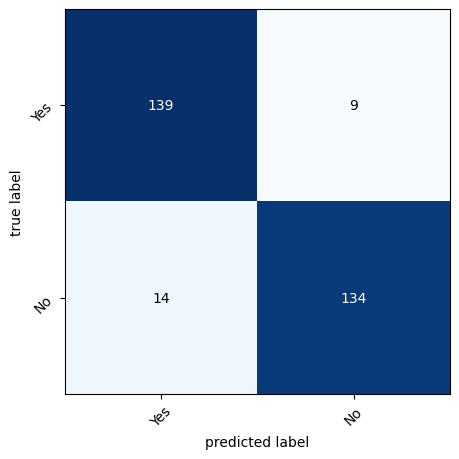

==========================Classification Report====================
Classification Report
              precision    recall  f1-score   support

         Yes       0.91      0.94      0.92       148
          No       0.94      0.91      0.92       148

    accuracy                           0.92       296
   macro avg       0.92      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296

==========================F1 Score====================
F1 Score: 0.9222751195899122


In [59]:
# Confusion Matrix and Classification Report
target_names = ['Yes', 'No']
# Plot confusion matrix
print("==========================Confusion Matrix====================")
Y_pred = EfficientNetV2S_model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, Y_pred_classes)
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
ax.set_xticklabels([''] + target_names, rotation=45)
ax.set_yticklabels([''] + target_names, rotation=45)
plt.show()

print("==========================Classification Report====================")
print('Classification Report')
print(classification_report(validation_generator.classes, Y_pred_classes, target_names=target_names))

# F1 Score
print("==========================F1 Score====================")
f1_EfficientNetV2S = f1_score(validation_generator.classes, Y_pred_classes, average='weighted')
print('F1 Score:', f1_EfficientNetV2S)

# Model Comparison

In [60]:
# Make dictionary of all models
models = {
    "DIY Arc Model": DIY_Model,
    "MobileNet V2": MobileNetV2_model,
    "DenseNet 121": DenseNet121_model,
    "Xception": Xception_model,
    "EfficientNetV2S":EfficientNetV2S_model
}

Accuracy ={
    "DIY Arc Model": scores_DIY[1],
    "MobileNet V2": scores_MobileNetV2[1],
    "DenseNet 121": scores_DenseNet121[1],
    "Xception": scores_Xception[1],
    "EfficientNetV2S":scores_EfficientNetV2S[1]
}

Loss = {
    "DIY Arc Model": scores_DIY[0],
    "MobileNet V2": scores_MobileNetV2[0],
    "DenseNet 121": scores_DenseNet121[0],
    "Xception": scores_Xception[0],
    "EfficientNetV2S":scores_EfficientNetV2S[0]
}

f1 = {
    "DIY Arc Model": f1_DIY,
    "MobileNet V2": f1_MobileNetV2,
    "DenseNet 121": f1_DenseNet121,
    "Xception": f1_Xception,
    "EfficientNetV2S":f1_EfficientNetV2S
}

# Make dataframe of all models, accuracy, loss, and f1 score
df = pd.DataFrame(list(zip(models.keys(), Accuracy.values(), Loss.values(), f1.values())), columns =['Model', 'Accuracy', 'Loss', 'F1'])

# Sort dataframe by accuracy
df = df.sort_values(by=['Accuracy'], ascending=False)

# Print dataframe
print(df)

             Model  Accuracy          Loss        F1
0    DIY Arc Model  1.000000  6.756964e-02  1.000000
1     MobileNet V2  1.000000  2.119391e-08  1.000000
2     DenseNet 121  1.000000  3.293247e-04  1.000000
3         Xception  1.000000  1.533012e-04  1.000000
4  EfficientNetV2S  0.922297  3.005626e-01  0.922275


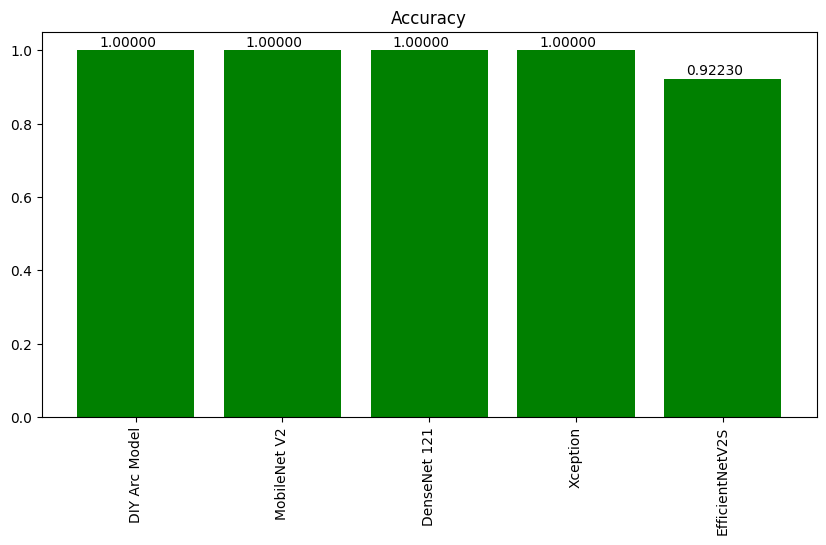

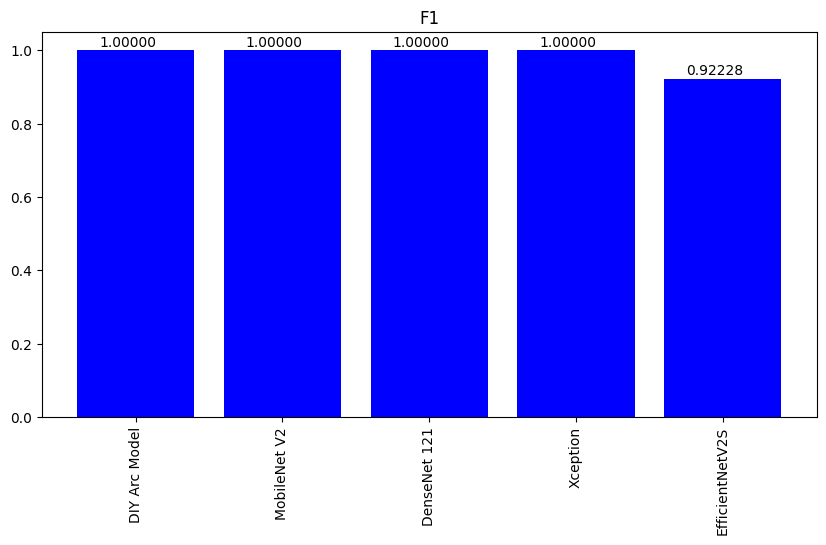

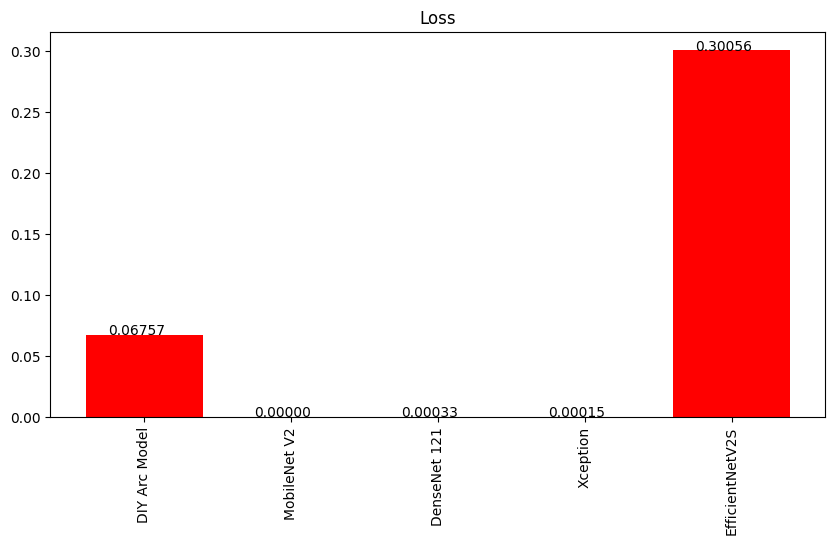

In [61]:
# make multiple plots for accuracy, f1 and loss with annotations
# Accuracy
plt.figure(figsize=(10, 5))
plt.title('Accuracy')
plt.bar(df['Model'], df['Accuracy'], color='green')
plt.xticks(rotation=90)
for i, v in enumerate(df['Accuracy']):
    plt.text(i - 0.25, v + 0.01, '{0:.5f}'.format(v))
plt.show()

# F1
plt.figure(figsize=(10, 5))
plt.title('F1')
plt.bar(df['Model'], df['F1'], color='blue')
plt.xticks(rotation=90)
for i, v in enumerate(df['F1']):
    plt.text(i - 0.25, v + 0.01, '{0:.5f}'.format(v))
plt.show()

# Loss
plt.figure(figsize=(10, 5))
plt.title('Loss')
plt.bar(df['Model'], df['Loss'], color='red')
plt.xticks(rotation=90)
for i, v in enumerate(df['Loss']):
    plt.text(i - 0.25, v + 0.0001, '{0:.5f}'.format(v))
plt.show()